In [88]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

In this notebook i describe an alternative way to find the text lines in the mrz. 
The task is to come up with an algorithm that, given the center coordinates of each angle bracket, assigns each bracket either to line 1 or 2 of the MRZ.

I choose to address this challenge using the sample image. In a first step I extract the centers of all angle brackets.

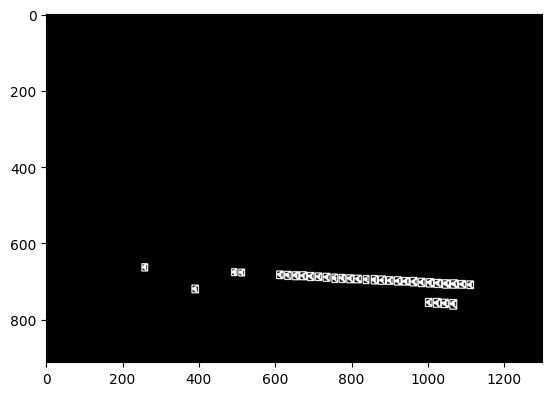

In [89]:
img = cv2.imread('highlighted.jpg',0)
img_copy = img.copy()
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
centers = []
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    center_x = int(x+w/2)
    center_y = int(y+h/2)
    cv2.rectangle(img, (x, y), (x+w,y+h), 255, 2)
    cv2.circle(img, (center_x, center_y), radius=5, color=255, thickness=-1)
    centers.append([center_x, center_y])

cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

plt.imshow(img, cmap="gray")

By using linear models I can get the slope of the MRZ lines. As we see in the plot, linear regression does not work well. MRZ regions usually have a lot more angle bracket in one line than the other. Thus I select RANSAC as my linear model of choice, as it has a good chance to fit to the line containing more angle brackets and disregarding the other angle brackets as outliers. 

In [90]:
import numpy as np
from sklearn import linear_model
# Input to our algorithm, a list of angle bracket centers
centers = np.array(centers)

lr = linear_model.LinearRegression()
lr.fit(centers[:, 0].reshape(-1,1), centers[:, 1])


# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(centers[:, 0].reshape(-1,1), centers[:, 1])
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(centers[:, 0].min(), centers[:, 0].max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)
print(lr.get_params())

Estimated coefficients (true, linear regression, RANSAC):
[0.06847208] [0.0540236]
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


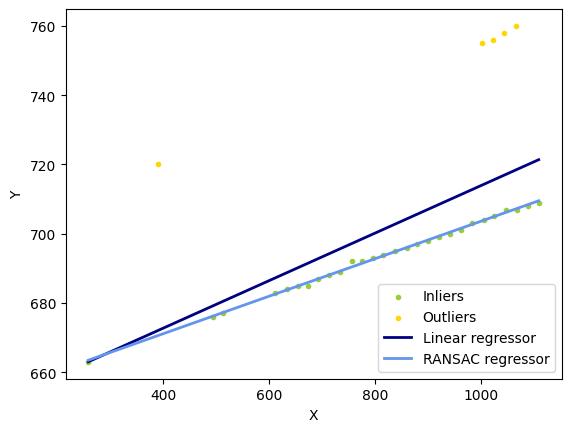

In [91]:
lw = 2
X = centers[:, 0]
y = centers[:, 1]
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

I define group 1 as those brackets that are closer to the RANSAC regression. By averaging the y coordinates of each group I could find out which group is line 1 and which line 2 in the original image.
In the last plot I show the groups. We can see that they are identical to the inlier and outlier groups in the previous plot.

In [92]:
y_distance_from_line = np.abs(centers[:, 1] - ransac.predict(centers[:, 0].reshape(-1, 1)))
print(y_distance_from_line.astype(int))

mean_distance = np.mean(y_distance_from_line)
group_1 = []
group_2 = []
for idx in range(len(centers)):
    if y_distance_from_line[idx] < mean_distance:
        group_1.append(centers[idx])
    else:
        group_2.append(centers[idx])


[52 51 51 51 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0]


[]

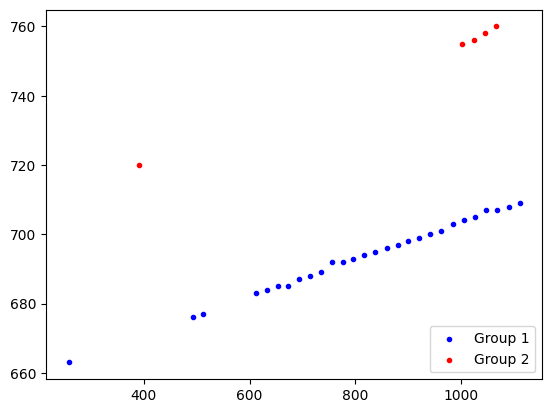

In [94]:
group_1 = np.array(group_1)
group_2 = np.array(group_2)
plt.scatter(
    group_1[:, 0], group_1[:, 1], color="blue", marker=".", label="Group 1"
)
plt.scatter(
    group_2[:, 0], group_2[:, 1], color="red", marker=".", label="Group 2"
)
plt.legend(loc="lower right")
plt.plot()

The plot is unfortuately turned upside down. This can be easily solved however.
Another very promising algorithm for detecting lines from a list of angle bracket coordinates is DBSCAN. I will try it in the future.